In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# Configurar dispositivo para GPU si está disponible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Usando el dispositivo: {device}')

Usando el dispositivo: cuda:0


In [3]:
# Cargar el modelo y el tokenizador pre-entrenado
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=5)  # 7 clases
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

In [4]:
# Mover el modelo a la GPU si está disponible
model.to(device='cuda:0')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

PREPARACION DE LOS DATOS

In [5]:
# seleccionamos el arhchivo datos_editados_18.95.csv

from google.colab import files

# Cargar el archivo desde el sistema local
uploaded = files.upload()

# Obtener el nombre del archivo cargado
file_name = list(uploaded.keys())[0]

# Listar los archivos en el directorio actual
!ls

# Obtener la ruta del archivo en el sistema de archivos de Colab
import os
current_directory = os.getcwd()
file_path = os.path.join(current_directory, file_name)
print("Ruta del archivo:", file_path)

Saving datos_editados_18_05_version1.csv to datos_editados_18_05_version1.csv
datos_editados_18_05_version1.csv  sample_data
Ruta del archivo: /content/datos_editados_18_05_version1.csv


In [6]:
datos_editados = pd.read_csv("datos_editados_18_05_version1.csv",encoding='latin1') # estos datos los hemos extraido de manera previa uniendo la variable "4"="CAOS" para ver si tenían mas relacion

In [7]:
print(len(datos_editados)) #1138

1388


In [8]:
print(datos_editados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Frase        1388 non-null   object
 1   Consensuada  1388 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.8+ KB
None


In [9]:
print(datos_editados.columns)

Index(['Frase', 'Consensuada'], dtype='object')


In [10]:
# Contar la frecuencia de cada valor
frequency = datos_editados['Consensuada'].value_counts().reset_index()
frequency.columns = ['Value', 'Frequency']

# Diccionario para mapear valores a estilos
value_to_style = {
    0: 'Estilo sin identificar',
    1: 'Apoyo a la autonomía',
    2: 'Estructura',
    3: 'Control',
    4: 'Caos'
}

# Mapear los valores a los estilos
frequency['Style'] = frequency['Value'].map(value_to_style)

# Crear el gráfico de barras con colores distintos
fig = px.bar(frequency, x='Value', y='Frequency', color='Style', title='Frecuencia de cada valor en la variable',
             labels={'Value':'Valor', 'Frequency':'Frecuencia', 'Style':'Estilo'})

# Mostrar el gráfico
fig.show()

In [ ]:
import plotly.graph_objects as go
# Diccionario para mapear valores a estilos
value_to_style = {
    0: 'Estilo sin identificar',
    1: 'Apoyo a la autonomía',
    2: 'Estructura',
    3: 'Control',
    4: 'Caos'
}

# Crear una lista de colores
colors = {
    'Estilo sin identificar': 'lightblue',
    'Apoyo a la autonomía': 'lightgreen',
    'Estructura': 'lightcoral',
    'Control': 'plum',
    'Caos': 'peachpuff'
}

# Crear las barras del gráfico
bars = []
for value, row in frequency.iterrows():
    style = value_to_style[row['Value']]
    bars.append(go.Bar(
        x=[row['Value']],
        y=[row['Frequency']],
        name=style,
        marker_color=colors[style]
    ))

# Crear el gráfico
fig = go.Figure(data=bars)

# Actualizar el layout del gráfico
fig.update_layout(
    title={
        'text': 'Frecuencia de cada valor en la variable',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Valor',
    yaxis_title='Frecuencia',
    barmode='group',
    width=900,  # Ancho del gráfico
    height=800  # Alto del gráfico
)

# Mostrar el gráfico
fig.show()

In [11]:
# En los datos de entrenamiento tendría que haber informacion suficiente para entrenar de todas las variables ( a destacar la variable 4 (CAOS))
train_texts, test_texts, train_labels, test_labels = train_test_split(datos_editados['Frase'], datos_editados['Consensuada'], test_size=0.2, random_state=42,stratify=datos_editados['Consensuada'] )


In [12]:
y = datos_editados.Consensuada

In [13]:
# RECUENTO POR CADA CLASE de la variable "Consensuada"
unique, counts = np.unique(y, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TOTAL %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TOTAL 0: Samples 275
Consensuada TOTAL 1: Samples 290
Consensuada TOTAL 2: Samples 456
Consensuada TOTAL 3: Samples 196
Consensuada TOTAL 4: Samples 171


In [14]:
# RECUENTO EN LOS DATOS DE ENTRENAMIENTO
unique, counts = np.unique(train_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TRAIN %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TRAIN 0: Samples 220
Consensuada TRAIN 1: Samples 232
Consensuada TRAIN 2: Samples 364
Consensuada TRAIN 3: Samples 157
Consensuada TRAIN 4: Samples 137


In [15]:
# Veamos ahora el recuento en los DATOS DE TEST
# Number of samples per class
unique, counts = np.unique(test_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TEST %i: Samples %i' % (unique[i], counts[i]) )
# efectivamente está mal porque

Consensuada TEST 0: Samples 55
Consensuada TEST 1: Samples 58
Consensuada TEST 2: Samples 92
Consensuada TEST 3: Samples 39
Consensuada TEST 4: Samples 34


In [16]:
!pip install transformers

In [17]:
# Calcular la longitud promedio de las frases en train_texts
lengths = [len(text.split()) for text in train_texts.tolist()]
avg_length = np.mean(lengths)
print(f"Longitud promedio de las frases: {avg_length:.2f}")

Longitud promedio de las frases: 14.99


In [18]:
# Tokenización y creación de datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True,max_length=20)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True,max_length=20)

In [19]:
train_labels = torch.tensor(train_labels.tolist()).to(device='cuda:0')
test_labels = torch.tensor(test_labels.tolist()).to(device='cuda:0')

## Convertimos ahora los datos a tensores de PyTorch

In [20]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(train_encodings['attention_mask']).to(device='cuda:0'),
    train_labels
)

In [21]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(test_encodings['attention_mask']).to(device='cuda:0'),
    test_labels
)

## Definimos el DataLoader para cargar los datos durante el entrenamiento

In [22]:
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

## Optimizador y funcion de perdida

In [23]:
# optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()




```
# max_length = 512
# lr = 2e-5
# stratify=datos_editados['Consensuada']
```



In [30]:
# 19/07 17:38

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in range(80):  # Cambia el número de épocas según necesites
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    train_accuracy = correct_predictions / total_predictions
    training_loss.append(total_loss / len(train_dataloader))
    training_accuracy.append(train_accuracy)

    # Evaluar en el conjunto de validación después de cada época
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_predictions += len(labels)

    val_accuracy = correct_val_predictions / total_val_predictions
    validation_loss.append(total_val_loss / len(test_dataloader))
    validation_accuracy.append(val_accuracy)

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {training_loss[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print("-" * 50)

Epoch 1
Training Loss: 0.0136, Training Accuracy: 0.9919
Validation Loss: 1.9838, Validation Accuracy: 0.7122
--------------------------------------------------
Epoch 2
Training Loss: 0.0134, Training Accuracy: 0.9892
Validation Loss: 1.9857, Validation Accuracy: 0.7158
--------------------------------------------------
Epoch 3
Training Loss: 0.0131, Training Accuracy: 0.9910
Validation Loss: 2.0094, Validation Accuracy: 0.7158
--------------------------------------------------
Epoch 4
Training Loss: 0.0142, Training Accuracy: 0.9910
Validation Loss: 2.0176, Validation Accuracy: 0.7122
--------------------------------------------------
Epoch 5
Training Loss: 0.0181, Training Accuracy: 0.9919
Validation Loss: 1.9834, Validation Accuracy: 0.7122
--------------------------------------------------
Epoch 6
Training Loss: 0.0139, Training Accuracy: 0.9901
Validation Loss: 2.0416, Validation Accuracy: 0.7122
--------------------------------------------------
Epoch 7
Training Loss: 0.0133, Tra

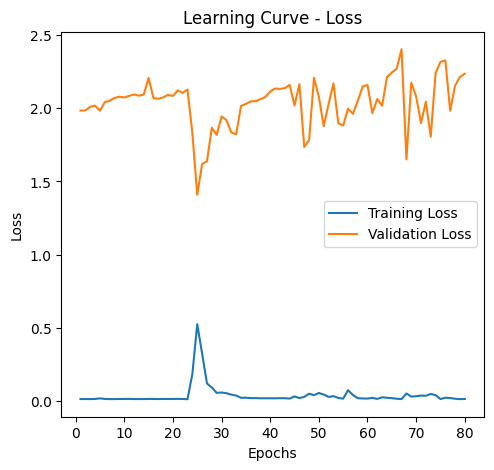

In [32]:
# Plot de la curva de pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 81), training_loss, label='Training Loss')
plt.plot(range(1, 81), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.show()

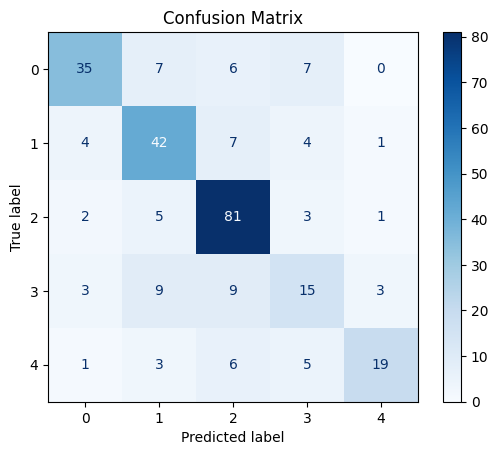

In [34]:
# matriz de confusión 19/07 18.01
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Lista para guardar etiquetas y predicciones para el conjunto de validación
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Convertir a arrays de NumPy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_predictions, labels=np.unique(all_labels))

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# 19/07 18.14

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Calcular el informe de clasificación
report = classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in np.unique(all_labels)])

# Imprimir el informe de clasificación
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.64      0.70        55
     Class 1       0.64      0.72      0.68        58
     Class 2       0.74      0.88      0.81        92
     Class 3       0.44      0.38      0.41        39
     Class 4       0.79      0.56      0.66        34

    accuracy                           0.69       278
   macro avg       0.68      0.64      0.65       278
weighted avg       0.69      0.69      0.68       278



In [25]:
training_loss = []
training_accuracy = []

for epoch in range(80):  # Cambia el número de épocas según necesites
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    train_accuracy = correct_predictions / total_predictions
    training_loss.append(total_loss / len(train_dataloader))
    training_accuracy.append(train_accuracy)

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {training_loss[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print("-" * 50)

Epoch 1
Training Loss: 0.0147, Training Accuracy: 0.9910
--------------------------------------------------
Epoch 2
Training Loss: 0.0138, Training Accuracy: 0.9892
--------------------------------------------------
Epoch 3
Training Loss: 0.0151, Training Accuracy: 0.9901
--------------------------------------------------
Epoch 4
Training Loss: 0.0141, Training Accuracy: 0.9910
--------------------------------------------------
Epoch 5
Training Loss: 0.0145, Training Accuracy: 0.9892
--------------------------------------------------
Epoch 6
Training Loss: 0.0175, Training Accuracy: 0.9874
--------------------------------------------------
Epoch 7
Training Loss: 0.0166, Training Accuracy: 0.9901
--------------------------------------------------
Epoch 8
Training Loss: 0.0155, Training Accuracy: 0.9892
--------------------------------------------------
Epoch 9
Training Loss: 0.0149, Training Accuracy: 0.9910
--------------------------------------------------
Epoch 10
Training Loss: 0.01

In [28]:
model.eval()
total_val_loss = 0
correct_val_predictions = 0
total_val_predictions = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_val_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct_val_predictions += (predictions == labels).sum().item()
        total_val_predictions += len(labels)

val_accuracy = correct_val_predictions / total_val_predictions
validation_loss.append(total_val_loss / len(test_dataloader))
validation_accuracy.append(val_accuracy)


In [26]:
validation_loss = []
validation_accuracy = []

model.eval()
total_val_loss = 0
correct_val_predictions = 0
total_val_predictions = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_val_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct_val_predictions += (predictions == labels).sum().item()
        total_val_predictions += len(labels)

val_accuracy = correct_val_predictions / total_val_predictions
validation_loss.append(total_val_loss / len(test_dataloader))
validation_accuracy.append(val_accuracy)



ValueError: x and y must have same first dimension, but have shapes (80,) and (2,)

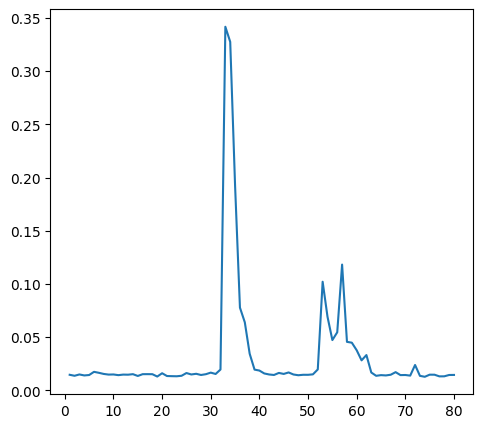

In [29]:
# Plot de la curva de pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 81), training_loss, label='Training Loss')
plt.plot(range(1, 81), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.show()


NameError: name 'validation_accuracy' is not defined

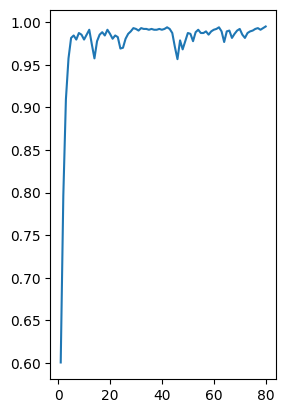

In [ ]:
# Plot de la curva de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, 81), training_accuracy, label='Training Accuracy')
plt.plot(range(1, 81), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()

plt.show()

In [ ]:
model.train()
for epoch in range(80):  # Cambia el número de épocas según necesites
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    accuracy = correct_predictions / total_predictions

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}, Loss: {total_loss}, Accuracy: {accuracy}")



Epoch 1, Loss: 77.9728245139122, Accuracy: 0.6055979643765903
Epoch 2, Loss: 41.6683519333601, Accuracy: 0.7998303647158609
Epoch 3, Loss: 19.063807480037212, Accuracy: 0.9211195928753181
Epoch 4, Loss: 11.042441999539733, Accuracy: 0.9558948261238338
Epoch 5, Loss: 7.334707879461348, Accuracy: 0.9694656488549618
Epoch 6, Loss: 4.981031039729714, Accuracy: 0.9754028837998303
Epoch 7, Loss: 3.1700944912154227, Accuracy: 0.9847328244274809
Epoch 8, Loss: 5.026487322058529, Accuracy: 0.9745547073791349
Epoch 9, Loss: 5.411196736153215, Accuracy: 0.9762510602205259
Epoch 10, Loss: 4.396322461543605, Accuracy: 0.981340118744699
Epoch 11, Loss: 3.1216384363360703, Accuracy: 0.9847328244274809
Epoch 12, Loss: 4.939132369472645, Accuracy: 0.9770992366412213
Epoch 13, Loss: 5.353255317313597, Accuracy: 0.9754028837998303
Epoch 14, Loss: 3.801870173541829, Accuracy: 0.9804919423240034
Epoch 15, Loss: 4.007664463948458, Accuracy: 0.9745547073791349
Epoch 16, Loss: 4.259899392724037, Accuracy: 0.9

## evaluacion del conjunto de pruebas

In [ ]:
# Evaluación del modelo
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
class_names = ['SE', 'AA', 'E', 'CON','CA']



In [ ]:
# Impresión de métricas de evaluación
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.71      0.83      0.76        72
           2       0.86      0.89      0.87       114
           3       0.49      0.45      0.47        49
           4       0.76      0.74      0.75        43

    accuracy                           0.75       347
   macro avg       0.72      0.71      0.71       347
weighted avg       0.75      0.75      0.75       347



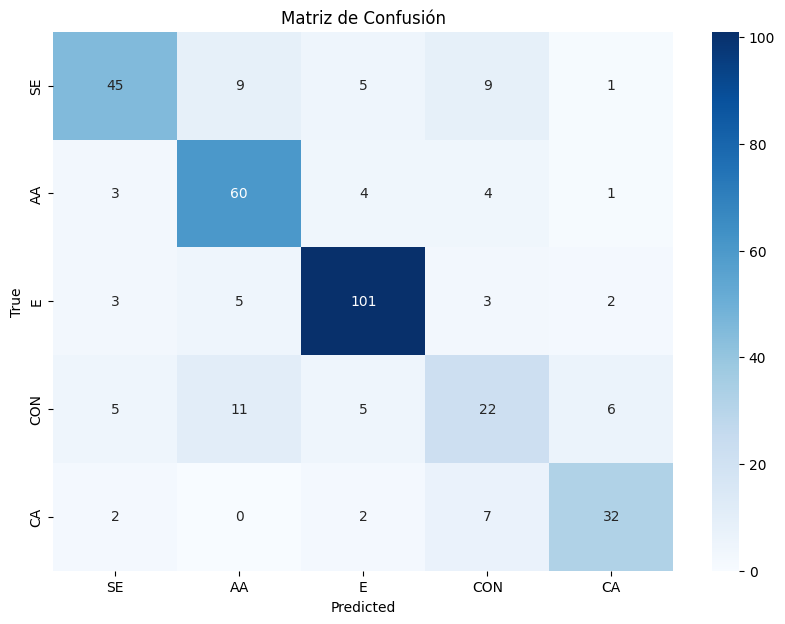

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()